Import necessary libraries

In [2]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [3]:
lr = 1e-4
image_size = 128
nepochs = 100
batch_size = 128

data_set_root = '/home/nithira/ImageCaptioning/Datasets'
train_set = 'train2017'
validation_set = 'val2017'

train_set_path = os.path.join(data_set_root, train_set)
train_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, train_set)

validation_set_path = os.path.join(data_set_root, validation_set)
validation_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, validation_set)

In [4]:
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample)-1)
        return sample[rand_index] 

In [5]:
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.AutoAugment(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])]) 

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

train_dataset = datasets.CocoCaptions(root=train_set_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

eval_dataset = datasets.CocoCaptions(root=validation_set_path,
                                     annFile=validation_ann_file,
                                     transform=transform,
                                     target_transform=SampleCaption())

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/home/nithira/ImageCaptioning/Datasets/annotations/captions_train2017.json'

In [48]:
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
data_loader_eval = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [50]:
dataiter = next(iter(data_loader_eval))
test_images, test_captions = dataiter
print("test_images shape:", test_images.shape)
print("test_captions:", test_captions)


test_images shape: torch.Size([128, 3, 128, 128])
test_captions: ('A room with chairs, a table, and a woman in it.', 'A big burly grizzly bear is show with grass in the background.', 'Bedroom scene with a bookcase, blue comforter and window.', 'A stop sign installed upside down on a street corner', 'A group of three stuffed animal teddy bears.', 'A young woman is skiing down the mountain slope. ', 'Kitchen appliances and cabinets as seen through opening.', 'Two men playing baseball in a field on a sunny day.', 'A man holding a tennis racket playing tennis.', 'a large family poses for picture on tennis court', 'A girl is taking a picture of people fishing.', 'A woman holds up her phone in front of her face.', 'A group of children ride on an indoor train.', 'A sandwich with a bite taken on a plate.', 'A man with a wet suit on standing on a surfboard in the water.', 'A laptop and desktop computer on a white desk', 'Some cars on the freeway are exiting onto Sunset Blvd.', 'a red double dec

A grilled chicken sandwich sits beside french fries made with real potatoes. 


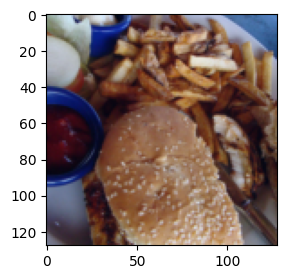

In [51]:
index = 100 

plt.figure(figsize=(3,3))
out = torchvision.utils.make_grid(test_images[index].unsqueeze(0), 1, normalize=True)
plt.imshow(out.numpy().transpose((1,2,0)))

caption = test_captions[index]
print(caption)

In [52]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
for i in range(64):
    print(tokenizer.tokenize(caption[i]))


['a']
[]
['g']
['r']
['i']
['l']
['l']
['e']
['d']
[]
['c']
['h']
['i']
['c']
['k']
['e']
['n']
[]
['s']
['a']
['n']
['d']
['w']
['i']
['c']
['h']
[]
['s']
['i']
['t']
['s']
[]
['b']
['e']
['s']
['i']
['d']
['e']
[]
['f']
['r']
['e']
['n']
['c']
['h']
[]
['f']
['r']
['i']
['e']
['s']
[]
['m']
['a']
['d']
['e']
[]
['w']
['i']
['t']
['h']
[]
['r']
['e']


In [53]:
tokenizer.vocab_size

30522

In [54]:
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors='pt')

In [55]:
token_ids = tokens['input_ids'][index]
tokens['input_ids']

tensor([[  101,  1037,  2282,  ...,     0,     0,     0],
        [  101,  1037,  2502,  ...,     0,     0,     0],
        [  101,  5010,  3496,  ...,     0,     0,     0],
        ...,
        [  101,  1037, 20956,  ...,     0,     0,     0],
        [  101,  1037,  2158,  ...,     0,     0,     0],
        [  101,  1996, 17260,  ...,     0,     0,     0]])

In [56]:
print(tokenizer.decode(token_ids))

[CLS] a grilled chicken sandwich sits beside french fries made with real potatoes. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [57]:
class TokenDrop(nn.Module):
    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob*torch.ones_like(sample)).long()

        can_drop = (~(sample == self.eos_token)).long()
        mask = mask*can_drop

        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()

        replace_with = (self.blank_token*torch.ones_like(sample)).long()

        sample_out = (1-mask)*sample + mask*replace_with

        return sample_out

In [58]:
def extract_patches(image_tensor, patch_size=16):
    bs, c, h, w = image_tensor.size()
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfolded = unfold(image_tensor)
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c*patch_size*patch_size)

    return unfolded

In [59]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim//2
        emb = math.log(10000)/(half_dim-1)
        emb = torch.exp(torch.arange(half_dim, device=device)*-emb)
        emb = x[:, None]*emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        
        return emb

In [60]:
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.embedding.weight.data = 0.001*self.embedding.weight.data

        self.pos_emb = SinusoidalPositionalEmbedding(hidden_size)

        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=hidden_size*4, dropout=0.0, batch_first=True)

        self.decoder_layers = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(hidden_size, num_emb)

    def forward(self, input_seq, encoder_output, input_padding_mask=None, encoder_padding_mask=None):
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        seq_index = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_index).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        causal_mask = torch.triu(torch.ones(l, l, device=input_seq.device), 1).bool()

        output = self.decoder_layers(tgt=embs, memory=encoder_output, tgt_mask=causal_mask, tgt_key_padding_mask=input_padding_mask, memory_key_padding_mask=encoder_padding_mask)

        return self.fc_out(output)

In [61]:
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()

        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in*patch_size*patch_size, hidden_size)

        seq_length = (image_size//patch_size)**2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.02))

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=hidden_size*4, dropout=0.0, batch_first=True)
        self.encoder_layers = nn.TransformerEncoder(encoder_layer, num_layers)
        
    def forward(self, image):
        bs = image.shape[0]
        
        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)
        
        embs = patch_emb + self.pos_embedding
        
        output = self.encoder_layers(embs)
        
        return output

In [62]:
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()

        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, patch_size=patch_size, hidden_size=hidden_size, num_layers=num_layers[0], num_heads=num_heads)
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        bool_padding_mask = padding_mask ==0
        encoded_seq = self.encoder(image=input_image)
        decoded_seq = self.decoder(input_seq=target_seq, encoder_output=encoded_seq, input_padding_mask=bool_padding_mask)

        return decoded_seq

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Embedding Size
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

# Create Model
caption_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], num_emb=tokenizer.vocab_size, patch_size=patch_size, num_layers=num_layers, hidden_size=hidden_size, num_heads=num_heads).to(device)

#Optimizer
optimizer = optim.Adam(caption_model.parameters(), lr=lr)

scaler = torch.cuda.amp.GradScaler()

# Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []


/tmp/ipykernel_843221/118429362.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [64]:
num_model_params = 0

for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("Number of model parameters: ", num_model_params)

Number of model parameters:  18067194


In [65]:
# Load Checkpoint
#cp = torch.load('captioning_model.pt')
#caption_model.load_state_dict(cp['model_state_dict'])
#optimizer.load_state_dict(cp['optimizer_state_dict'])
#training_loss_logger = cp['train_data_logger']
#eval_loss_logger = cp['eval_data_logger']
#start_epoch = cp['epoch']

In [66]:
for epoch in trange(0, nepochs, leave=False, desc='Epoch'):
    caption_model.train()
    steps = 0 

    for images, captions in tqdm(data_loader_train, desc='Training', leave=False):
        images = images.to(device)

        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors='pt')
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]

        target_ids = torch.cat((token_ids[:, 1:], torch.zeros(bs, 1, device=device).long()), 1)

        tokens_in = td(token_ids)

        with torch.cuda.amp.autocast(enabled=True):
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)

        loss = (loss_fn(pred.transpose(1, 2), target_ids)*padding_mask).mean()

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Log the training loss
        training_loss_logger.append(loss.item())

    

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

/tmp/ipykernel_843221/186352784.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Training:   0%|          | 0/925 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Training Loss')

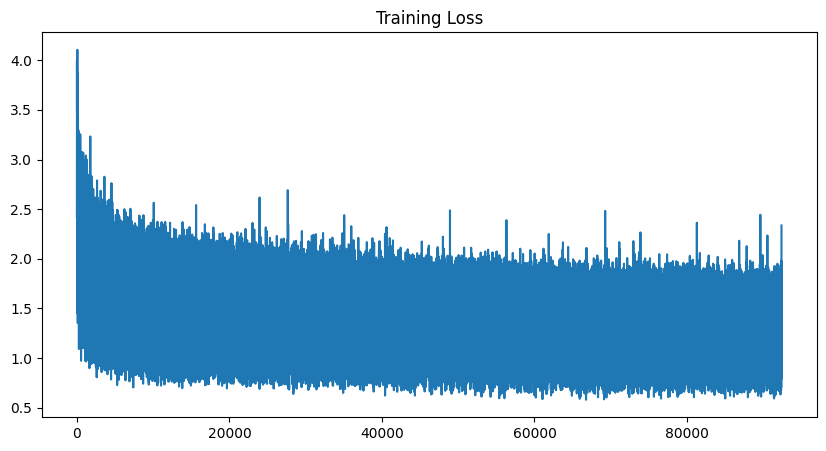

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(training_loss_logger[100:])
plt.title('Training Loss')

Text(0.5, 1.0, 'Training Loss')

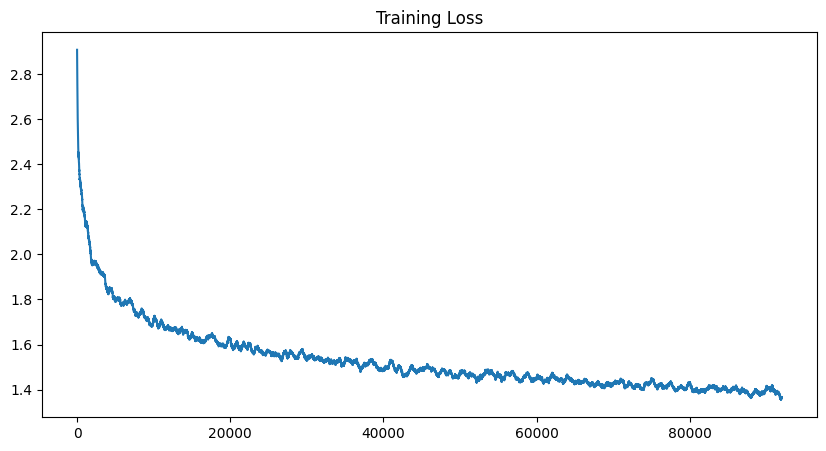

In [68]:
window_size = 512
data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(data[0:])
plt.title('Training Loss')

In [69]:
dataiter = next(iter(data_loader_eval))
test_images, test_captions = dataiter

In [129]:
index = 7
test_image = test_images[index].unsqueeze(0)

In [1]:
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)

plt.imshow(out.numpy().transpose((1, 2, 0)))
print(test_captions[index])

NameError: name 'plt' is not defined

In [131]:
sos_token = 101*torch.ones(1, 1).long()
temp = 0.5

In [133]:
log_tokens = [sos_token]
caption_model.eval()

with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=True):
        image_embedding = caption_model.encoder(test_image.to(device))

    for i in range(50):
        input_tokens = torch.cat(log_tokens, 1)

        data_pred = caption_model.decoder(input_tokens.to(device), image_embedding)

        dist = Categorical(logits=data_pred[:, -1]/temp)
        next_tokens = dist.sample().reshape(1, 1)

        log_tokens.append(next_tokens.cpu())

        if next_tokens.item() == 102:
            break

/tmp/ipykernel_843221/2509216960.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


In [134]:
# Convert the list of token indices to a tensor
pred_text = torch.cat(log_tokens, 1)

# Convert the token indices to their corresponding strings using the vocabulary
pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

# Join the token strings to form the predicted text
pred_text = "".join(pred_text_strings)

print(pred_text)

a young boy in a baseball uniform playing baseball.


a young boy in a baseball uniform playing baseball.


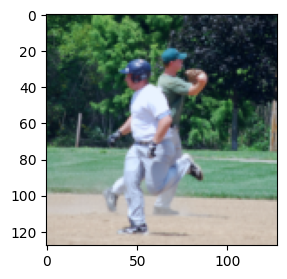

In [135]:
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)

plt.imshow(out.numpy().transpose((1, 2, 0)))

print(pred_text)

In [97]:
print(caption_model.state_dict())

OrderedDict([('encoder.pos_embedding', tensor([[[ 4.3768e-02,  2.7904e-01,  5.8226e-02,  ..., -6.2794e-02,
          -4.9922e-02, -9.4320e-02],
         [ 1.0100e-01,  2.0881e-01,  1.3829e-01,  ..., -7.6745e-02,
           9.2672e-04, -6.3647e-02],
         [ 6.2165e-02,  2.3713e-01,  1.3388e-01,  ..., -1.0410e-01,
           1.5081e-04, -4.1125e-02],
         ...,
         [ 7.6422e-03, -4.4798e-02,  6.7174e-02,  ..., -1.8386e-01,
          -1.9364e-01, -1.2332e-01],
         [-3.2703e-02, -1.8868e-02,  5.2979e-02,  ..., -1.3883e-01,
          -2.2252e-01, -1.1688e-01],
         [-2.2961e-02,  5.3576e-02,  2.9387e-02,  ..., -8.4016e-02,
          -2.1691e-01, -1.1412e-01]]], device='cuda:0')), ('encoder.fc_in.weight', tensor([[-0.0165, -0.0403,  0.0249,  ...,  0.0458,  0.0717,  0.0163],
        [ 0.0802, -0.0534, -0.0561,  ...,  0.0363,  0.0269, -0.0155],
        [-0.0398, -0.0475,  0.0345,  ...,  0.0325,  0.0142,  0.0685],
        ...,
        [-0.0786, -0.0705, -0.0877,  ..., -0.065

In [98]:
# Save the model
checkpoint = {
    'model_state_dict': caption_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_data_logger': training_loss_logger,
    'epoch': nepochs
}

torch.save(checkpoint, 'captioning_model.pt')
